## OD 패턴 기반 클러스터링:

유사한 물동량 패턴을 가진 구들을 그룹화
물류 특성이 비슷한 구들을 식별 가능


## 다익스트라 알고리즘 활용:

물동량을 가중치의 역수로 사용하여 '실질적' 최단경로 도출
클러스터 간 효율적인 물류 경로 파악 가능


분석 결과:

OD 행렬 시각화
클러스터링 결과
네트워크 구조
클러스터 간 평균 경로 길이

In [11]:
import  pandas as pd

In [12]:
daily_volume=pd.read_csv('총물동량.csv', encoding='cp949')

In [13]:
import matplotlib.pyplot as plt
from matplotlib import rc

# macOS
plt.rc('font', family='AppleGothic') 
plt.rcParams['axes.unicode_minus'] = False

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [17]:

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # Mac
# plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['axes.unicode_minus'] = False

def create_od_vectors(daily_volume):
    """
    구별 OD 동선벡터 생성
    
    Returns:
    --------
    od_vectors : DataFrame
        구별 OD 패턴 벡터
    od_matrix : ndarray
        평균 OD 행렬
    """
    districts = sorted(list(set(daily_volume['송하인_구명'].unique()) | 
                          set(daily_volume['수하인_구명'].unique())))
    n_districts = len(districts)
    district_to_idx = {district: idx for idx, district in enumerate(districts)}
    
    od_matrix = np.zeros((n_districts, n_districts))
    
    for _, row in daily_volume.iterrows():
        i = district_to_idx[row['송하인_구명']]
        j = district_to_idx[row['수하인_구명']]
        od_matrix[i][j] += row['총_물동량']
    
    od_matrix = od_matrix / od_matrix.sum()
    od_vectors = pd.DataFrame(index=districts)
    
    for i, district in enumerate(districts):
        od_vectors[f'{district}_발송'] = od_matrix[i, :]
    
    for i, district in enumerate(districts):
        od_vectors[f'{district}_수신'] = od_matrix[:, i]
    
    return od_vectors, od_matrix, districts

def cluster_districts(od_vectors, n_clusters=5):
    """
    구별 OD 패턴 클러스터링
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(od_vectors)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_data)
    
    cluster_results = pd.DataFrame({
        '구': od_vectors.index,
        '클러스터': clusters
    })
    
    return cluster_results, kmeans.cluster_centers_

def create_weighted_graph(od_matrix, districts):
    """
    가중 그래프 생성 및 최단경로 분석
    """
    G = nx.DiGraph()
    
    for district in districts:
        G.add_node(district)
    
    n_districts = len(districts)
    for i in range(n_districts):
        for j in range(n_districts):
            if od_matrix[i,j] > 0:
                weight = 1 / od_matrix[i,j]
                G.add_edge(districts[i], districts[j], weight=weight)
    
    return G

def analyze_shortest_paths(G, cluster_results):
    """
    클러스터 간 최단경로 분석
    """
    paths_analysis = []
    
    clusters = cluster_results['클러스터'].unique()
    for c1 in clusters:
        for c2 in clusters:
            if c1 != c2:
                districts1 = cluster_results[cluster_results['클러스터'] == c1]['구']
                districts2 = cluster_results[cluster_results['클러스터'] == c2]['구']
                
                for d1 in districts1:
                    for d2 in districts2:
                        try:
                            path = nx.shortest_path(G, d1, d2, weight='weight')
                            length = nx.shortest_path_length(G, d1, d2, weight='weight')
                            paths_analysis.append({
                                '출발_클러스터': c1,
                                '도착_클러스터': c2,
                                '출발지': d1,
                                '도착지': d2,
                                '경로': '->'.join(path),
                                '경로_길이': length
                            })
                        except nx.NetworkXNoPath:
                            continue
    
    return pd.DataFrame(paths_analysis)

def visualize_results(od_matrix, cluster_results, G, districts):
    """
    분석 결과 시각화
    """
    fig = plt.figure(figsize=(20, 20))
    
    # 1. OD 행렬 히트맵 (좌상단)
    ax1 = plt.subplot(2, 2, 1)
    sns.heatmap(od_matrix, ax=ax1, cmap='YlOrRd')
    ax1.set_title('물동량 OD 행렬', pad=20, fontsize=14)
    ax1.set_xlabel('도착지', fontsize=12)
    ax1.set_ylabel('출발지', fontsize=12)
    
    # 2. 클러스터링 결과 (우상단)
    ax2 = plt.subplot(2, 2, 2)
    cluster_matrix = pd.crosstab(
        cluster_results['클러스터'], 
        columns='count'
    ).sort_index()
    cluster_matrix.plot(kind='bar', ax=ax2)
    ax2.set_title('클러스터별 구 분포', pad=20, fontsize=14)
    ax2.set_xlabel('클러스터', fontsize=12)
    ax2.set_ylabel('구 수', fontsize=12)
    
    # 3. 네트워크 그래프 (좌하단)
    ax3 = plt.subplot(2, 2, 3)
    pos = nx.spring_layout(G, k=1.5, iterations=50)  # k 값을 늘려 노드 간격 확대
    nx.draw(G, pos, ax=ax3, with_labels=True, 
            node_color='lightblue', node_size=1000, 
            font_size=8, font_weight='bold',
            width=0.5, edge_color='gray', alpha=0.6)
    ax3.set_title('물류 네트워크 구조', pad=20, fontsize=14)
    
    # 4. 클러스터 간 평균 최단경로 길이 (우하단)
    ax4 = plt.subplot(2, 2, 4)
    cluster_distances = np.zeros((len(cluster_results['클러스터'].unique()), 
                                len(cluster_results['클러스터'].unique())))
    
    for c1 in cluster_results['클러스터'].unique():
        for c2 in cluster_results['클러스터'].unique():
            if c1 != c2:
                districts1 = cluster_results[cluster_results['클러스터'] == c1]['구']
                districts2 = cluster_results[cluster_results['클러스터'] == c2]['구']
                
                distances = []
                for d1 in districts1:
                    for d2 in districts2:
                        try:
                            dist = nx.shortest_path_length(G, d1, d2, weight='weight')
                            distances.append(dist)
                        except nx.NetworkXNoPath:
                            continue
                
                if distances:
                    cluster_distances[c1][c2] = np.mean(distances)
    
    sns.heatmap(cluster_distances, ax=ax4, cmap='YlOrRd')
    ax4.set_title('클러스터 간 평균 최단경로 길이', pad=20, fontsize=14)
    ax4.set_xlabel('도착 클러스터', fontsize=12)
    ax4.set_ylabel('출발 클러스터', fontsize=12)
    
    plt.tight_layout(pad=3.0)  # 여백 늘리기
    return fig

def run_od_path_analysis(daily_volume, n_clusters=5):
    """
    전체 분석 프로세스 실행
    """
    print("1. OD 벡터 생성 중...")
    od_vectors, od_matrix, districts = create_od_vectors(daily_volume)
    
    print("2. 클러스터링 수행 중...")
    cluster_results, cluster_centers = cluster_districts(od_vectors, n_clusters)
    
    print("3. 가중 그래프 생성 중...")
    G = create_weighted_graph(od_matrix, districts)
    
    print("4. 최단경로 분석 중...")
    paths_df = analyze_shortest_paths(G, cluster_results)
    
    print("5. 결과 시각화 중...")
    fig = visualize_results(od_matrix, cluster_results, G, districts)
    
    return od_vectors, cluster_results, paths_df, fig

1. OD 벡터 생성 중...
2. 클러스터링 수행 중...
3. 가중 그래프 생성 중...
4. 최단경로 분석 중...
5. 결과 시각화 중...


/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48513 (\N{HANGUL SYLLABLE BUG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-

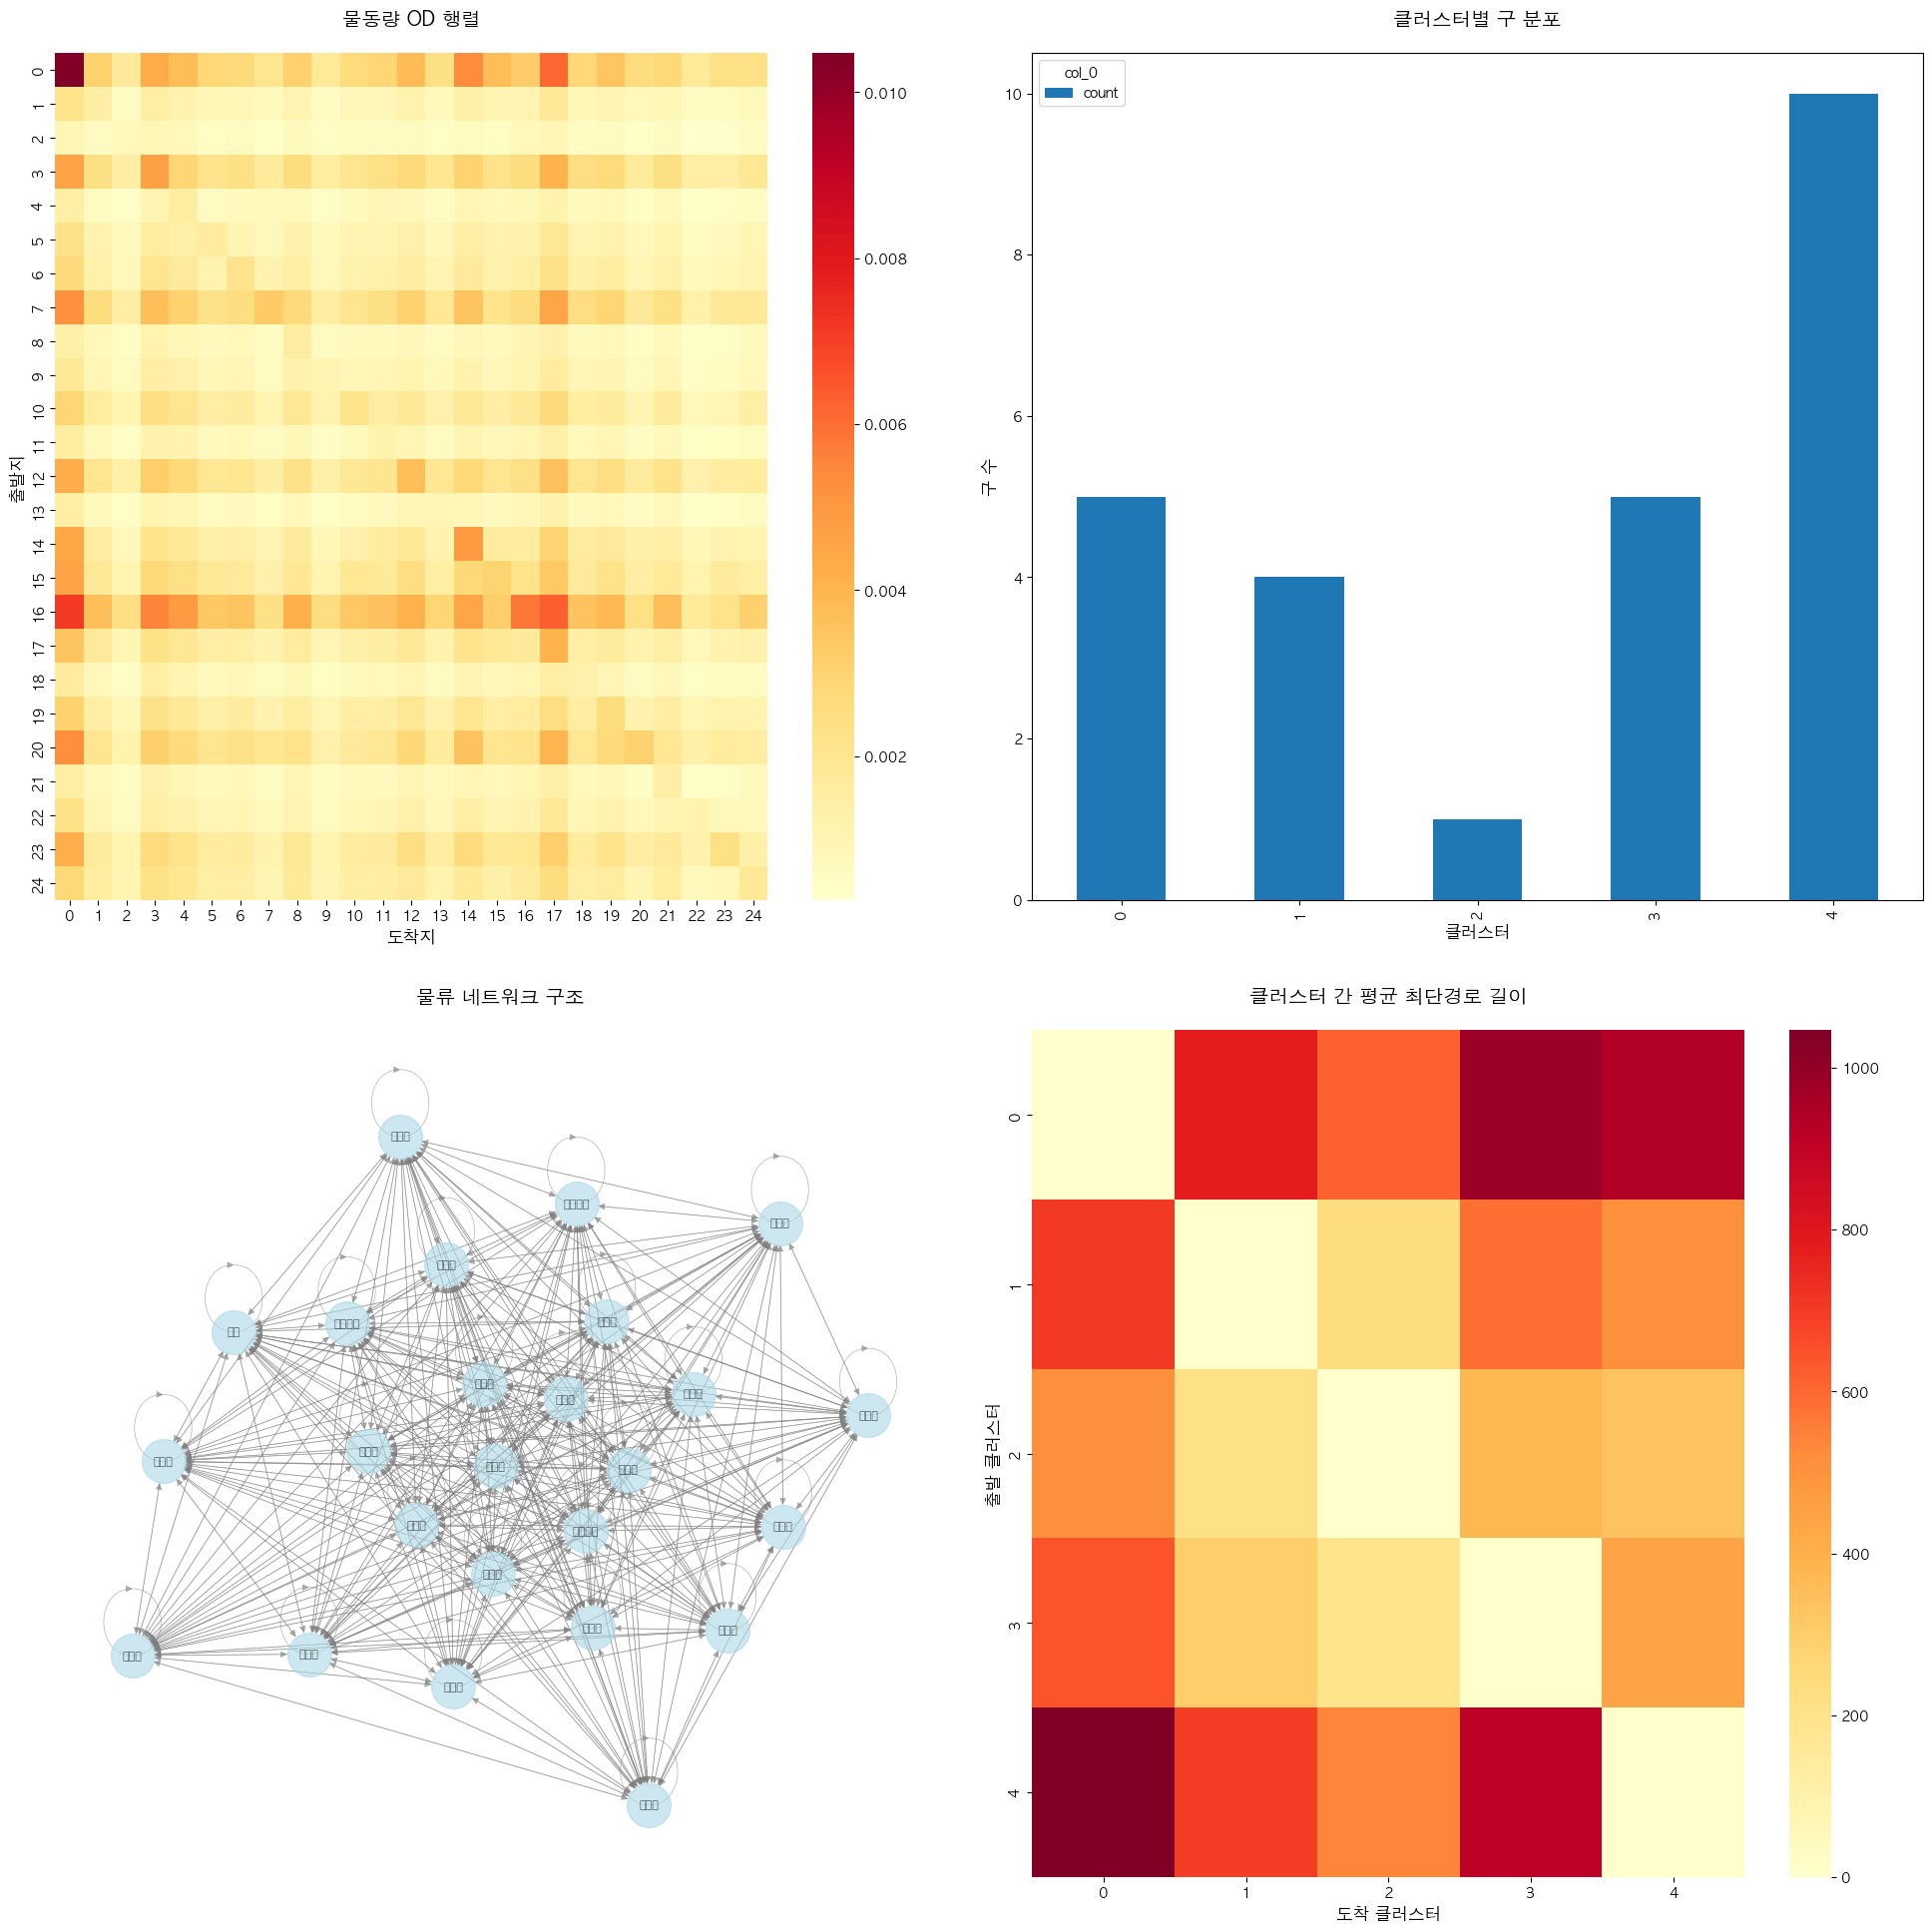


클러스터별 구 분포:
클러스터
0                           [강북구, 도봉구, 서대문구, 종로구, 중랑구]
1                                 [강서구, 마포구, 서초구, 송파구]
2                                                [강남구]
3                             [금천구, 성동구, 성북구, 용산구, 중구]
4    [강동구, 관악구, 광진구, 구로구, 노원구, 동대문구, 동작구, 양천구, 영등포구...
Name: 구, dtype: object

주요 물류 경로:
     출발_클러스터  도착_클러스터  출발지  도착지        경로       경로_길이
360        3        2  성북구  강남구  성북구->강남구  139.692879
449        3        1  성북구  송파구  성북구->송파구  158.493192
18         2        1  강남구  송파구  강남구->송파구  162.292347
446        3        1  성북구  강서구  성북구->강서구  180.263344
17         2        1  강남구  서초구  강남구->서초구  184.829815


In [18]:
# 데이터 로드 후
od_vectors, cluster_results, paths_df, fig = run_od_path_analysis(daily_volume)
plt.show()

# 결과 확인
print("\n클러스터별 구 분포:")
print(cluster_results.groupby('클러스터')['구'].apply(list))

print("\n주요 물류 경로:")
print(paths_df.sort_values('경로_길이').head())

In [19]:
def analyze_shortest_paths(G, cluster_results):
    """
    클러스터 간 최단경로 분석 및 다익스트라 경로 데이터프레임 생성
    
    Returns:
    --------
    paths_df : DataFrame
        모든 최단경로 정보를 담은 데이터프레임
    dijkstra_details_df : DataFrame
        상세한 다익스트라 경로 정보를 담은 데이터프레임
    """
    paths_analysis = []
    dijkstra_details = []
    
    clusters = cluster_results['클러스터'].unique()
    for c1 in clusters:
        for c2 in clusters:
            if c1 != c2:
                districts1 = cluster_results[cluster_results['클러스터'] == c1]['구']
                districts2 = cluster_results[cluster_results['클러스터'] == c2]['구']
                
                for d1 in districts1:
                    for d2 in districts2:
                        try:
                            path = nx.shortest_path(G, d1, d2, weight='weight')
                            length = nx.shortest_path_length(G, d1, d2, weight='weight')
                            
                            # 기본 경로 정보
                            paths_analysis.append({
                                '출발_클러스터': c1,
                                '도착_클러스터': c2,
                                '출발지': d1,
                                '도착지': d2,
                                '경로': '->'.join(path),
                                '경로_길이': length
                            })
                            
                            # 상세 다익스트라 경로 정보
                            for i in range(len(path)-1):
                                edge_weight = G[path[i]][path[i+1]]['weight']
                                dijkstra_details.append({
                                    '출발_클러스터': c1,
                                    '도착_클러스터': c2,
                                    '출발지': d1,
                                    '도착지': d2,
                                    '경로_순서': i+1,
                                    '구간_출발': path[i],
                                    '구간_도착': path[i+1],
                                    '구간_가중치': edge_weight,
                                    '총_경로_길이': length,
                                    '전체_경로': '->'.join(path)
                                })
                                
                        except nx.NetworkXNoPath:
                            continue
    
    paths_df = pd.DataFrame(paths_analysis)
    dijkstra_details_df = pd.DataFrame(dijkstra_details)
    
    return paths_df, dijkstra_details_df

def run_od_path_analysis(daily_volume, n_clusters=5, output_path='다익스트라_경로_데이터.csv'):
    """
    전체 분석 프로세스 실행 및 결과 저장
    
    Parameters:
    -----------
    daily_volume : DataFrame
        일별 물동량 데이터
    n_clusters : int
        클러스터 수
    output_path : str
        결과를 저장할 CSV 파일 경로
    """
    print("1. OD 벡터 생성 중...")
    od_vectors, od_matrix, districts = create_od_vectors(daily_volume)
    
    print("2. 클러스터링 수행 중...")
    cluster_results, cluster_centers = cluster_districts(od_vectors, n_clusters)
    
    print("3. 가중 그래프 생성 중...")
    G = create_weighted_graph(od_matrix, districts)
    
    print("4. 최단경로 분석 중...")
    paths_df, dijkstra_details_df = analyze_shortest_paths(G, cluster_results)
    
    print("5. 결과 시각화 중...")
    fig = visualize_results(od_matrix, cluster_results, G, districts)
    
    # CSV 파일로 저장
    print(f"6. 다익스트라 경로 데이터 저장 중... ({output_path})")
    dijkstra_details_df.to_csv(output_path, index=False, encoding='utf-8-sig')
    
    print("분석 완료!")
    return od_vectors, cluster_results, dijkstra_details_df, fig

# 사용 예시:
"""
# 데이터 로드 후
od_vectors, cluster_results, dijkstra_df, fig = run_od_path_analysis(
    daily_volume,
    n_clusters=5,
    output_path='다익스트라_경로_데이터.csv'
)

# 결과 확인
print("\n저장된 다익스트라 경로 데이터 미리보기:")
print(dijkstra_df.head())

# 시각화
plt.show()
"""

'\n# 데이터 로드 후\nod_vectors, cluster_results, dijkstra_df, fig = run_od_path_analysis(\n    daily_volume,\n    n_clusters=5,\n    output_path=\'다익스트라_경로_데이터.csv\'\n)\n\n# 결과 확인\nprint("\n저장된 다익스트라 경로 데이터 미리보기:")\nprint(dijkstra_df.head())\n\n# 시각화\nplt.show()\n'

1. OD 벡터 생성 중...
2. 클러스터링 수행 중...
3. 가중 그래프 생성 중...
4. 최단경로 분석 중...
5. 결과 시각화 중...


/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48513 (\N{HANGUL SYLLABLE BUG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-

6. 다익스트라 경로 데이터 저장 중... (다익스트라_경로_데이터.csv)
분석 완료!
1. OD 벡터 생성 중...
2. 클러스터링 수행 중...
3. 가중 그래프 생성 중...
4. 최단경로 분석 중...
5. 결과 시각화 중...


/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48513 (\N{HANGUL SYLLABLE BUG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-

6. 다익스트라 경로 데이터 저장 중... (my_dijkstra_results.csv)
분석 완료!


/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 48513 (\N{HANGUL SYLLABLE BUG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Use

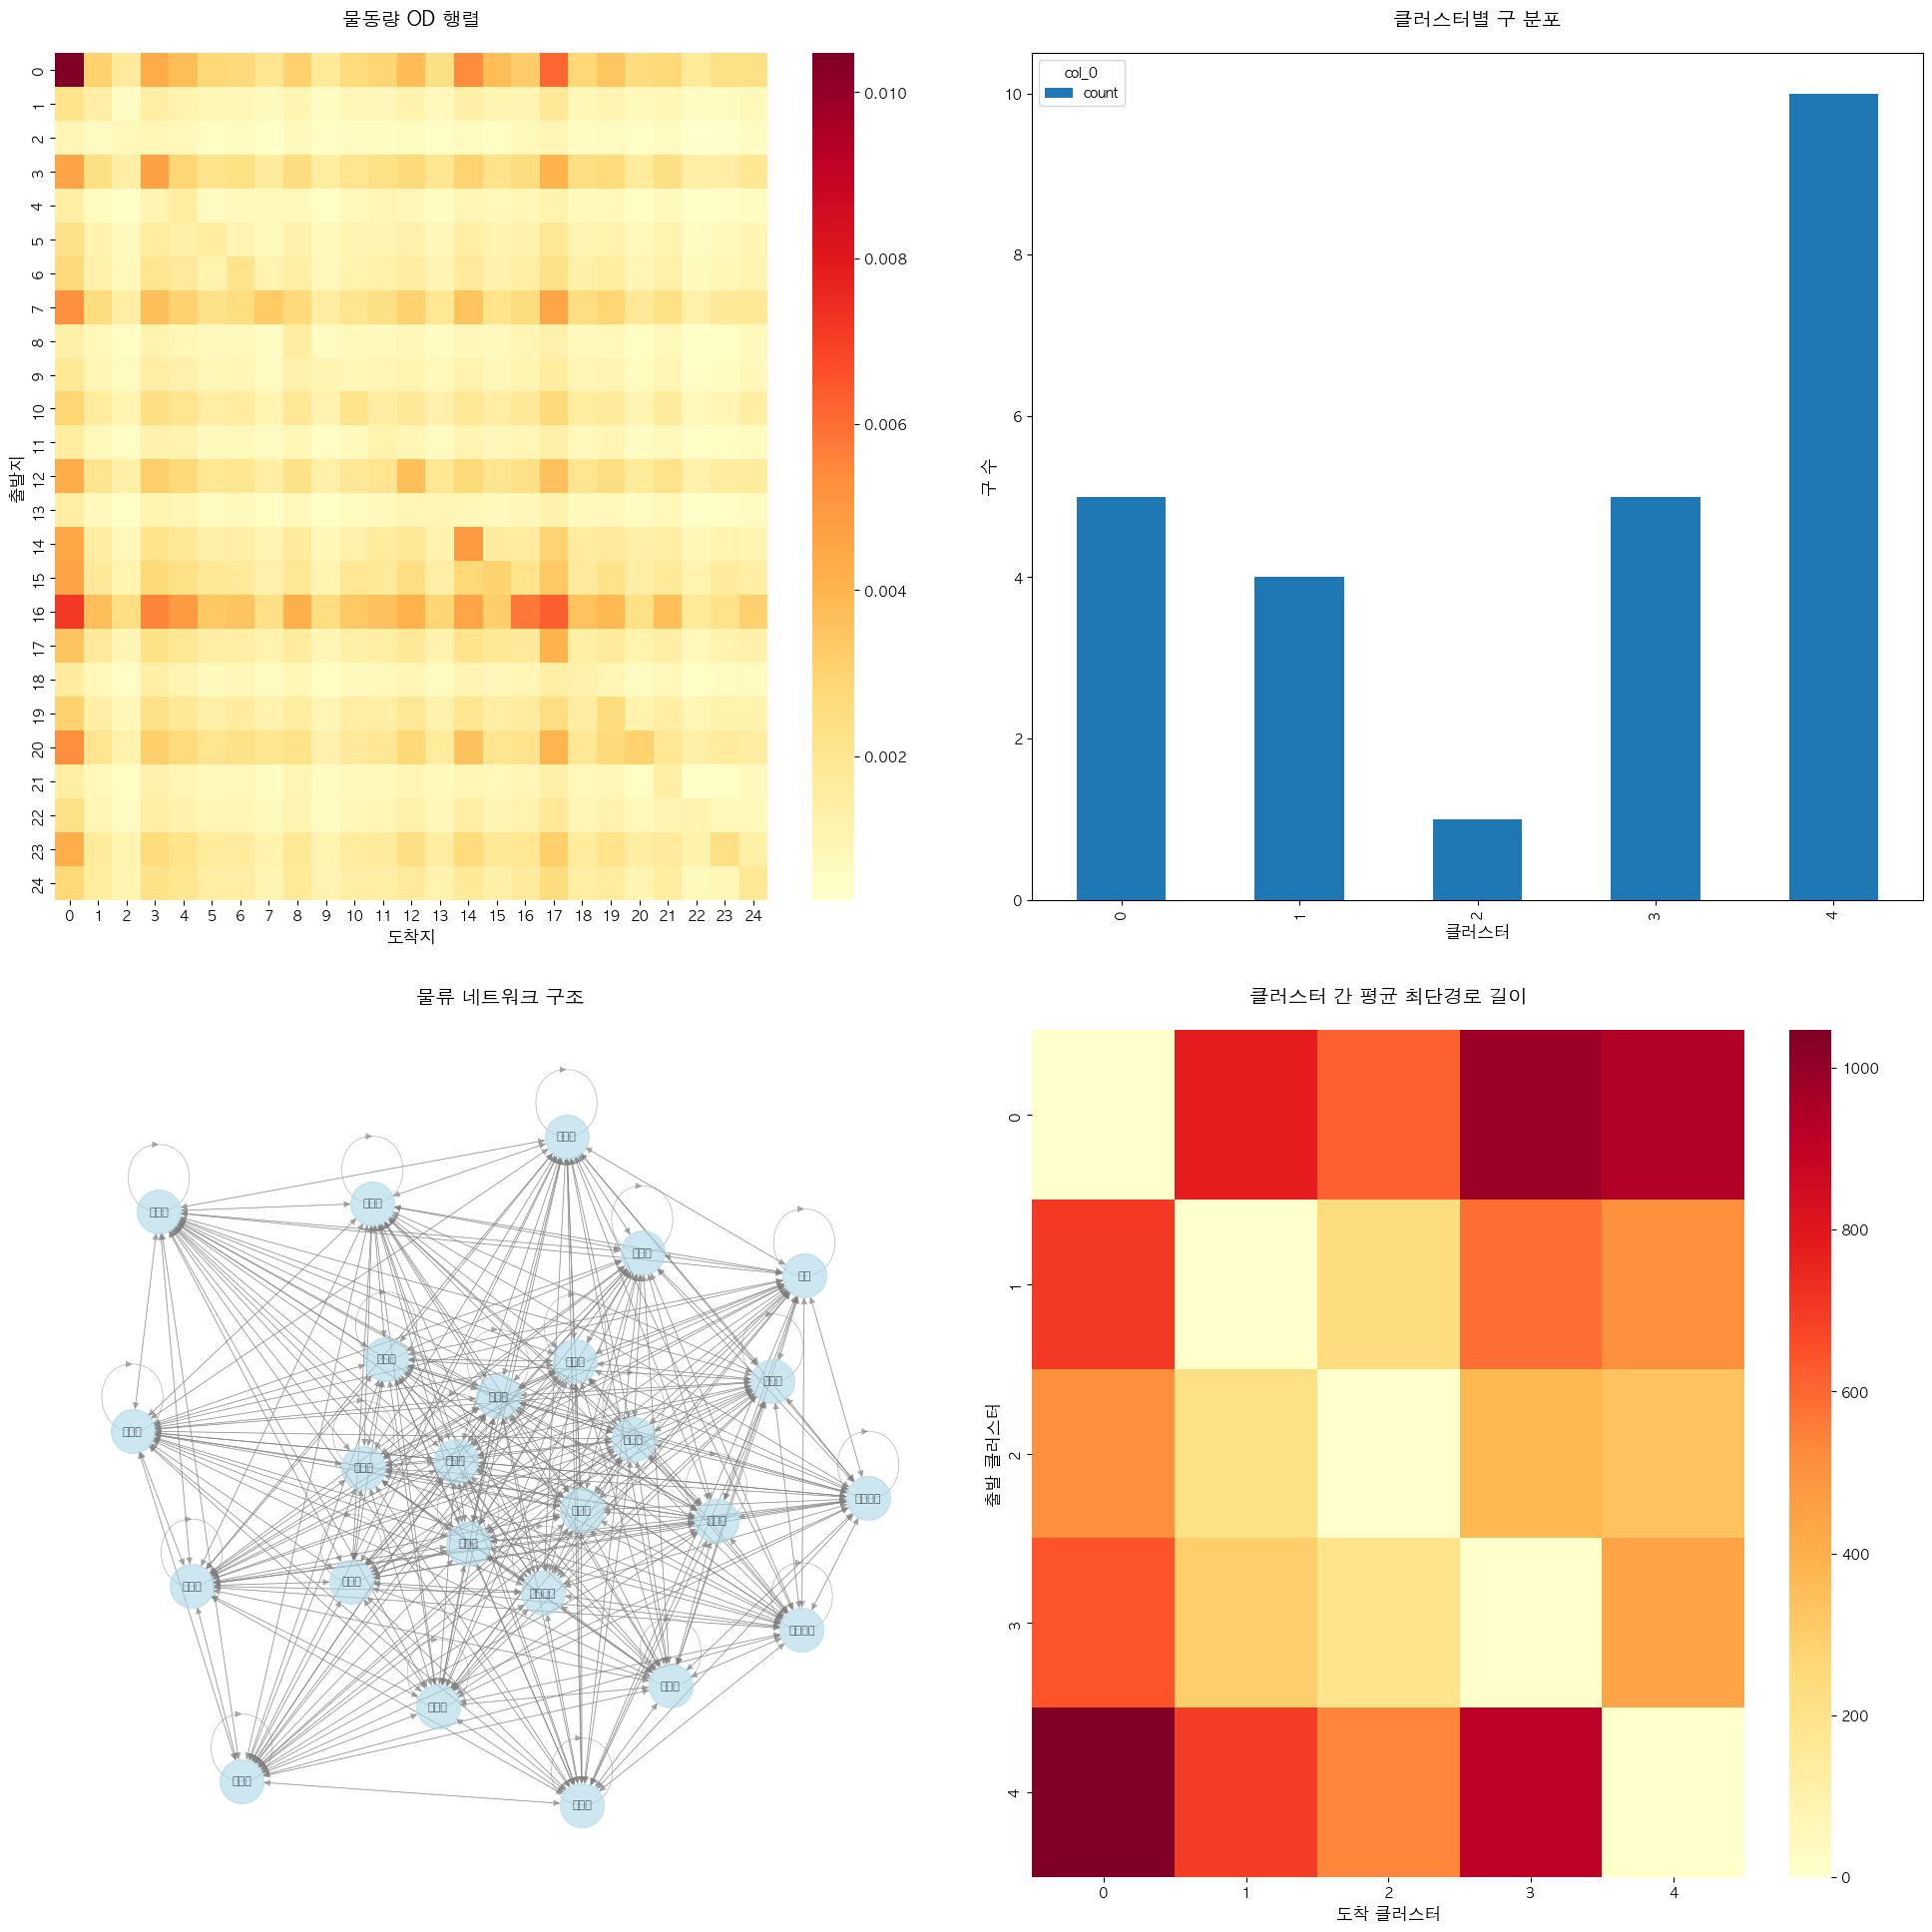

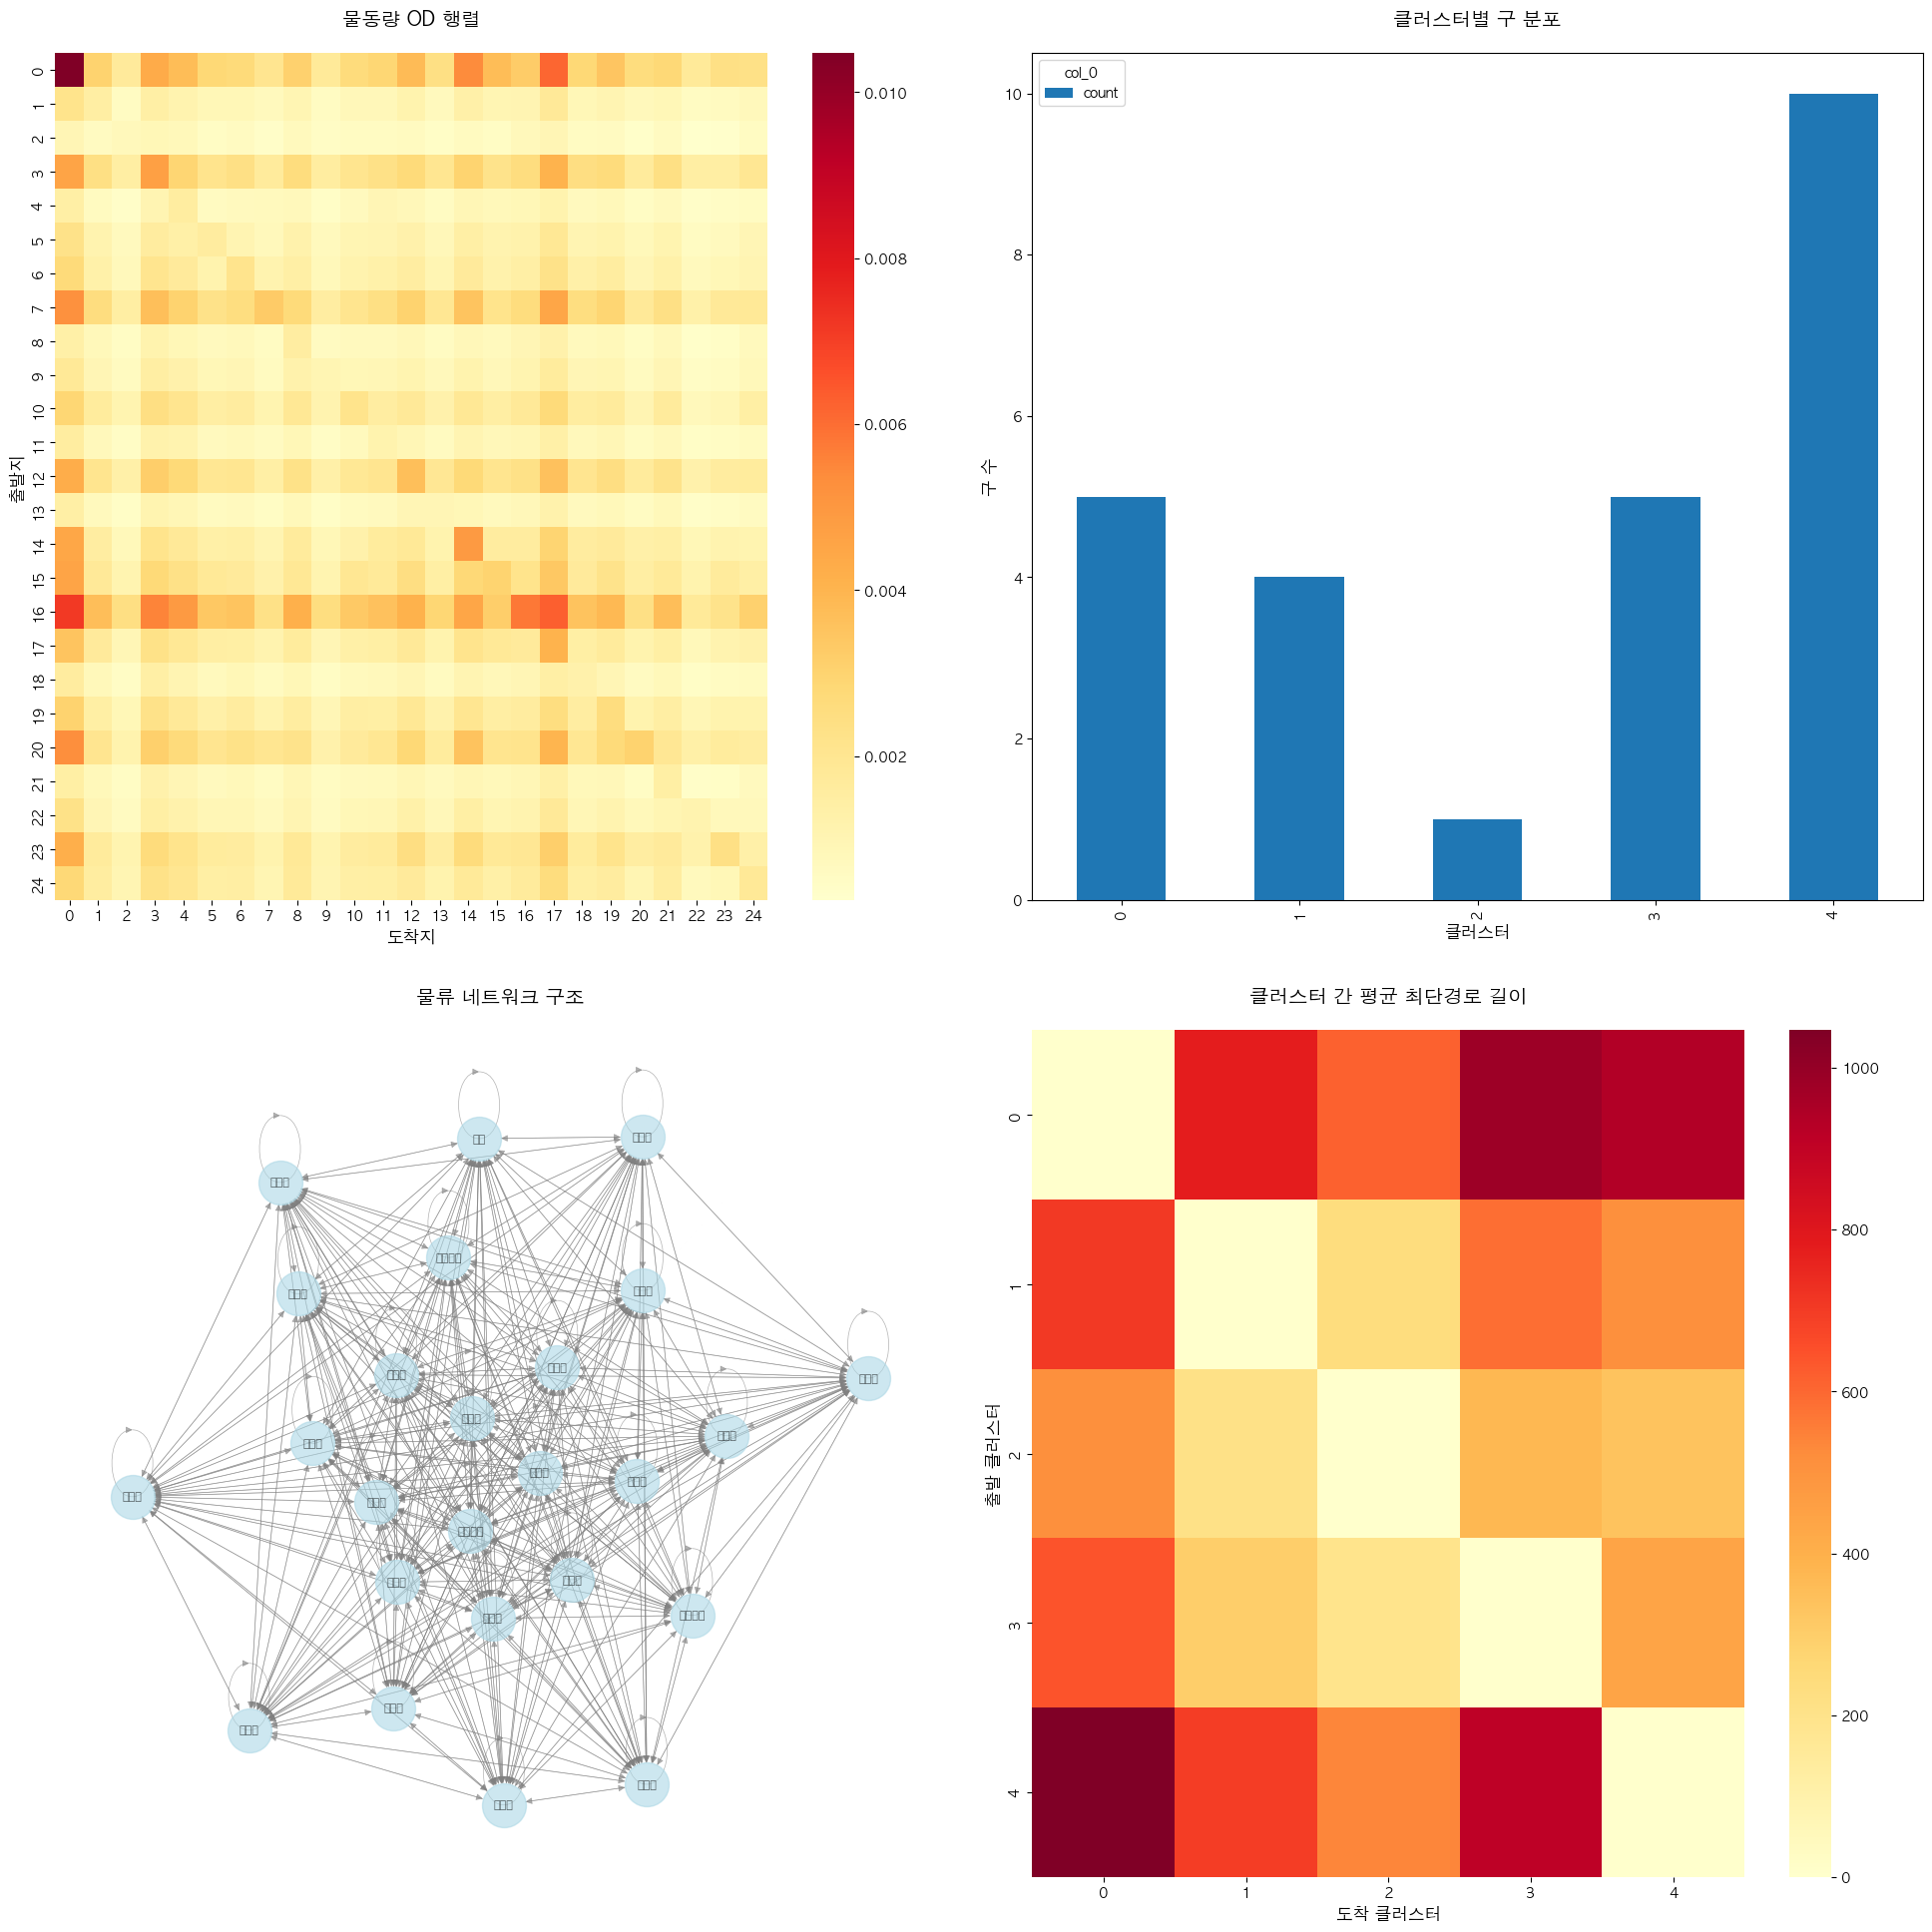

In [20]:
# 기본 파일명으로 저장
od_vectors, cluster_results, dijkstra_df, fig = run_od_path_analysis(daily_volume)

# 사용자 지정 파일명으로 저장
od_vectors, cluster_results, dijkstra_df, fig = run_od_path_analysis(
    daily_volume,
    output_path='my_dijkstra_results.csv'
)